In [2]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import optimize

In [3]:
# Test parameter
ConstitutiveModels = ['NeoHookean', 'Ogden']
ConstitutiveModel  = ConstitutiveModels[1]

StretchRange = [0.1, 5.0]                    # Stretch ratio interval
StretchDelta =  0.01                         # Step size

# Material Parameters
LambdaValue =  1E6   # 1st Lamé parameter
MuValue     =  660   # 2nd Lamé parameter (Shear modulus) (Pa)

C01Value    =  0.00   # Mooney-Rivlin 3rd material constant (kPa) if == 0 => Neo-Hookean
JmValue     =  0.08   # Gent 3rd material constant (-) if == 1 => ~Neo-Hookean with ln
BetaValue   =  20.3   # Demiray 3rd material constant (-) if == 1 => ~Neo-Hookean with exp
AlphaValue  = -24.3   # Ogden 3rd material constant (-) if == 2 => Neo-Hookean

# Folder for the results
Output_Path = os.path.join('Results','Compressible',ConstitutiveModel)
os.makedirs(Output_Path, exist_ok=True)
StretchArray = np.arange(StretchRange[0],StretchRange[1],StretchDelta)
AnalyticalStress = pd.DataFrame({'Stretch ratio (-)':StretchArray})

In [4]:
# Symbolic material parameters
Lambda, Mu   = symbols(r'\lambda \mu', positive=True)

# Identity tensor
I = eye(3)

# Direction vectors
e1 = I[:,0]
e2 = I[:,1]
e3 = I[:,2]

# Dilatation coefficients
LambdaH = 1                                      # Coefficient for homogeneous dilatation
LambdaX = symbols(r'\lambda_x', positive=True)   # Coefficient for lengthening in e1 direction (here <1)
LambdaY = symbols(r'\lambda_y', positive=True)   # Coefficient for lengthening in e2 direction (here <1)
LambdaZ = symbols(r'\lambda_z', positive=True)   # Coefficient for lengthening in e3 direction (here >1)

# Deformation matrices
U = I + (LambdaX-1) * np.outer(e1,e1) + (LambdaY-1) * np.outer(e2,e2) + (LambdaZ-1) * np.outer(e3,e3)

# Gradient of the deformation
F = (LambdaH-1) * I + U

# Volume change
J = det(F)

# Right Cauchy-Green strain tensor
C = transpose(F) * F

# Eigenvalues of Right Cauchy-Green strain tensor
Lambda1, Lambda2, Lambda3 = symbols(r'\lambda_1 \lambda_2 \lambda_3')

# Invariants
J, I1, I2, I1b, I2b = symbols(r'J I_1 I_2 \bar{I_1} \bar{I_2}')
JFunction   = Lambda1*Lambda2*Lambda3
I1Function  = Lambda1**2+Lambda2**2+Lambda3**2
I2Function  = Lambda1**2*Lambda2**2 + Lambda2**2*Lambda3**2 + Lambda3**2*Lambda1**2
I1bFunction = J**Rational(-2,3)*I1
I2bFunction = J**Rational(-4,3)*I2

# Hyperelastic models (Compressible)
if ConstitutiveModel == ConstitutiveModels[0]:     # Neo-Hookean
    C1, D1       = symbols(r'C_1 D_1', positive=True)
    C1Function   = Mu / 2
    D1Function   = Lambda / 2
    Psi          = C1 * (I1b - 3) + D1 * (J-1)**2
    print('Constitutive Model')
    display(Psi)
    Psi = Psi.subs({C1:C1Function, D1:D1Function})
    PsiLambda = Psi.subs({I1b:I1bFunction,I2b:I2bFunction})
    PsiLambda = PsiLambda.subs({J:JFunction,I1:I1Function,I2:I2Function})
    
    Parameters = [Lambda, Mu]
    Values     = [LambdaValue, MuValue]
    
if ConstitutiveModel == ConstitutiveModels[1]:     # Ogden
    Alpha, D1  = symbols(r'\alpha D_{1}', positive=True)
    D1Function = Lambda / 2
    lambda1N, lambda2N, lambda3N = symbols(r'\bar{\lambda}_1 \bar{\lambda}_2 \bar{\lambda}_3', positive=True)
    lambda1NFunction= J**(-Rational(1,3)) * Lambda1
    lambda2NFunction= J**(-Rational(1,3)) * Lambda2
    lambda3NFunction= J**(-Rational(1,3)) * Lambda3
    Psi = 2 * Mu * ( lambda1N**(Alpha) + lambda2N**(Alpha) + lambda3N**(Alpha) - 3) / Alpha**2 + D1 * (J-1)**2
    print('Constitutive Model')
    display(Psi)
    Psi = Psi.subs({D1:D1Function})
    PsiLambda = Psi.subs({lambda1N:lambda1NFunction, lambda2N:lambda2NFunction, lambda3N:lambda3NFunction})
    PsiLambda = PsiLambda.subs({J:JFunction})
    
    Parameters = [Lambda, Mu, Alpha]
    Values     = [LambdaValue, MuValue, AlphaValue]

T1 = Lambda1*Derivative(PsiLambda, Lambda1) / (Lambda1*Lambda2*Lambda3)
T1 = T1.doit()

T2 = Lambda2*Derivative(PsiLambda, Lambda2) / (Lambda1*Lambda2*Lambda3)
T2 = T2.doit()

T3 = Lambda3*Derivative(PsiLambda, Lambda3) / (Lambda1*Lambda2*Lambda3)
T3 = T3.doit()

# Uniaxial stretch
LambdaY = LambdaX

JFunction_Uniaxial = JFunction.subs({Lambda1:LambdaX, Lambda2:LambdaY, Lambda3:LambdaZ})
LambdaXFunction_Uniaxial = solve(JFunction_Uniaxial-J, LambdaX)[1]

T = T1 * np.outer(e1,e1) + T2 *np.outer(e2,e2) + T3 * np.outer(e3,e3)
T = Matrix(T).doit()
T = simplify(T)
T = T.subs({Lambda1:LambdaXFunction_Uniaxial,Lambda2:LambdaXFunction_Uniaxial,Lambda3:LambdaZ})

F = F.subs({LambdaX:LambdaXFunction_Uniaxial,LambdaY:LambdaXFunction_Uniaxial,Lambda3:LambdaZ})
P = J * T * F.inv().transpose()               # Nominal stress

PxxFunction = lambdify((LambdaZ, J, Parameters), P[0,0], 'numpy')
PzzFunction = lambdify((LambdaZ, J, Parameters), P[2,2], 'numpy')

# Estimate the value of J
JEquation = P[0,0]
JEquationPrime = diff(P[0,0], J)
JEstimation = lambdify((J, LambdaZ, Parameters), JEquation, 'numpy')
JEstimationPrime = lambdify((J, LambdaZ, Parameters), JEquationPrime, 'numpy')

def JComputation(Stretch, Values):
    JComputed = optimize.root_scalar(JEstimation, x0=1, args=(Stretch, Values), method='newton', fprime=JEstimationPrime)
    return JComputed

def StressComputation(StretchArray, Values):
    
    Pxx = np.zeros(StretchArray.shape)
    Pzz = np.zeros(StretchArray.shape)
    
    for i in range(StretchArray.shape[0]):
        Stretch = StretchArray[i]
        try:
            JComputed  = JComputation(Stretch, Values)
            JEstimated = JComputed.root
            Pxx[i] = PxxFunction(Stretch, JEstimated, Values)
            Pzz[i] = PzzFunction(Stretch, JEstimated, Values)
        except Exception as e:
            print(e)
            Pxx[i] = np.nan
            Pzz[i] = np.nan
            
    return Pzz, Pxx

Pzz, Pxx = StressComputation(StretchArray, Values)

if ConstitutiveModel == ConstitutiveModels[0]:                # Neo-Hookean
    AnalyticalStress[ConstitutiveModel + ' Pzz (Pa)'] = Pzz
    AnalyticalStress[ConstitutiveModel + ' Pxx (Pa)'] = Pxx
    AnalyticalStress.to_csv(os.path.join(Output_Path,'Lambda' + str(LambdaValue/1E6) + 'E6_Mu' + str(MuValue) + '.csv'), index=False)
    
if ConstitutiveModel == ConstitutiveModels[1]:                # Ogden
    AnalyticalStress[ConstitutiveModel + ' Pzz (Pa)'] = Pzz
    AnalyticalStress[ConstitutiveModel + ' Pxx (Pa)'] = Pxx
    AnalyticalStress.to_csv(os.path.join(Output_Path,'Lambda' + str(LambdaValue/1E6) + 'E6_Mu' + str(MuValue) + '_Alpha' + str(AlphaValue) + '.csv'), index=False)

Constitutive Model


D_{1}*(J - 1)**2 + 2*\mu*(\bar{\lambda}_1**\alpha + \bar{\lambda}_2**\alpha + \bar{\lambda}_3**\alpha - 3)/\alpha**2

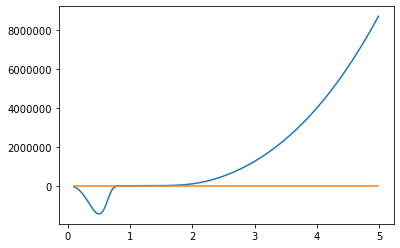

In [9]:
plt.plot(StretchArray,Pzz)
plt.plot(StretchArray,Pxx)
plt.show()